# Data Preparation and Cleaning
<hr>

#### Objectives
- Load the dataset from Hugging Face (source: lukebarousse/data_jobs).
- Inspect and clean key columns (dates, skills, job titles, salary fields).
- Handle missing values and inconsistent data types.
- Estimate missing annual salaries using grouped median values.
- Export the cleaned dataset for future analysis.


### Importing libraries and loading dataset 
<hr>

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datasets import load_dataset

# importing dataset
dataset = load_dataset("lukebarousse/data_jobs")['train'].to_pandas()
dataset.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,None,NaN,NaN,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,None,NaN,NaN,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."


### Data Profiling and Exploratory Analysis
<hr>

In [84]:
df = dataset.copy()

# Function to get data type for columns
def get_detailed_dtype(series):

    if series.dtype != 'object':
        return str(series.dtype)
    
    # Get the first non-null value (if one exists)
    non_null_series = series.dropna()
    if non_null_series.empty:
        return 'object (empty)'
    
    # Get the type of the first item
    first_item_type = type(non_null_series.iloc[0])
    
    if first_item_type == str:
        return 'string'
    elif first_item_type == list:
        return 'list'
    elif first_item_type == dict:
        return 'dict'
    else:
        return first_item_type.__name__

def get_nunique(series):
    try:
        return series.nunique()
    except TypeError:
        return 'N/A (unhashable)'


profile = pd.DataFrame({
    'Data Type': df.apply(get_detailed_dtype),
    'Non-Null Count': df.notnull().sum(),
    'Missing Count': df.isnull().sum(),
    'Missing %': round(df.isnull().mean() * 100, 2),
    'Unique Count': df.apply(get_nunique),
})

profile

,Data Type,Non-Null Count,Missing Count,Missing %,Unique Count
job_title_short,string,785741,0,0.00,10
job_title,string,785740,1,0.00,234673
job_location,string,784696,1045,0.13,17217
job_via,string,785733,8,0.00,7903
job_schedule_type,string,773074,12667,1.61,47
job_work_from_home,bool,785741,0,0.00,2
search_location,string,785741,0,0.00,173
job_posted_date,string,785741,0,0.00,607192
job_no_degree_mention,bool,785741,0,0.00,2
job_health_insurance,bool,785741,0,0.00,2


In [85]:
# Baisc EDA
total_postings = df.job_title_short.count()

# Country wise posting
country_wise_postings = df.job_country.value_counts().reset_index(name='job_count')
country_wise_postings.set_index('job_country', inplace=True)
country_wise_postings["% share"] = (country_wise_postings["job_count"] / total_postings * 100).round(1)
country_wise_postings.head(7)

,job_count,% share
job_country,,
United States,206292,26.3
India,51088,6.5
United Kingdom,40375,5.1
France,39922,5.1
Germany,27694,3.5
Spain,25100,3.2
Singapore,23696,3.0


Note: I will be choosing United States for the analysis as it has the highest job share and the US market sets global standards for skills, roles, and salary trends.


In [86]:
# exploring the salary column
df['salary_year_avg'].describe()
df[df.salary_year_avg.notna()].job_title_short.value_counts()

job_title_short
Data Scientist               5922
Data Analyst                 5451
Data Engineer                4500
Senior Data Scientist        1690
Senior Data Engineer         1591
Senior Data Analyst          1131
Business Analyst              610
Machine Learning Engineer     576
Software Engineer             467
Cloud Engineer                 65
Name: count, dtype: int64

Note: The salary columns contains a lot of null values that need to be filled properly.

### Data Cleaning
<hr>

#### Required Data Processing Steps

<b>1. Data Type Conversion:</b> Parse <code>job_posted_date</code> to datetime format and convert <code>job_skills</code> to a list structure.<br>
<b>2. Column Optimization:</b> Remove irrelevant or redundant columns.<br>
<b>3. Data Filtering:</b> Retain only records from the <b>United States</b> and restrict the dataset to <b>full-time positions</b>.<br>
<b>4. Role Refinement:</b> Exclude non–data-focused roles (e.g., <i>Software Engineer</i>, <i>Cloud Engineer</i>).<br>
<b>5. Missing Value Handling:</b> Impute null values in salary-related columns using appropriate median-based methods.
<br>


In [87]:
# data parsing
df['job_posted_date'] = pd.to_datetime(df.job_posted_date).dt.date
df['job_skills'] = df['job_skills'].apply(lambda skills: ast.literal_eval(skills) if pd.notna(skills) else skills)

# droping unnessary columns
df.drop(columns=
        ['job_type_skills', 'salary_hour_avg', 'salary_rate', 'search_location'], 
        inplace=True
)
df.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,2023-06-16,False,False,United States,NaN,Boehringer Ingelheim,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,2023-01-14,False,False,Mexico,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]"
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,2023-10-10,False,False,Germany,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,2023-07-04,True,False,United States,NaN,Southwest Research Institute,"[python, c++, java, matlab, aws, tensorflow, k..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,2023-08-07,False,False,Sudan,NaN,Kristina Daniel,"[bash, python, oracle, aws, ansible, puppet, j..."


In [88]:
# Focusing on US market only
df_US = df[df.job_country == 'United States'].copy()
df_US.sample()

# job title wise postings
df_US.job_title_short.value_counts()

# Focusing only on full time roles
df_US.job_schedule_type.value_counts().head()
df_US_filtered = df_US[df_US.job_schedule_type == 'Full-time'].copy()
df_US_filtered.job_schedule_type.count()

# Removing none data jobs
non_data_job = ['Cloud Engineer', 'Software Engineer']
df_US_filtered = df_US_filtered.drop(df_US_filtered[df_US_filtered['job_title_short'].isin(non_data_job)].index)

# sorting and reindex filtered datasets
df_US_filtered.sort_values(by='job_posted_date', ascending=True, inplace=True)
df_US_filtered.reset_index(inplace=True, drop=True)
df_US_filtered.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills
0,Data Analyst,Sr Data Analyst,"Tampa, FL",via Trabajo.org,Full-time,False,2023-01-01,False,False,United States,NaN,"TWO95 International, Inc","[sql, sql server, excel, ssrs, power bi, power..."
1,Data Analyst,Product Managers Data analyst,"Boston, MA",via LinkedIn,Full-time,False,2023-01-01,False,False,United States,NaN,Diverse Lynx,[sql]
2,Data Scientist,AI/ML Radar Research Data Scientist Jobs,"San Diego, CA",via Clearance Jobs,Full-time,False,2023-01-01,False,False,United States,NaN,Leidos,"[python, matlab]"
3,Data Analyst,Data Management Analyst,"Dallas, TX",via Indeed,Full-time,False,2023-01-01,False,False,United States,NaN,KORE1 Technologies,"[sql, excel, tableau, terminal]"
4,Data Scientist,Data Science Consultant,"San Francisco, CA",via Mendeley,Full-time,False,2023-01-01,False,False,United States,NaN,Resume Library,None


### Understanding salary distribution 
<hr>

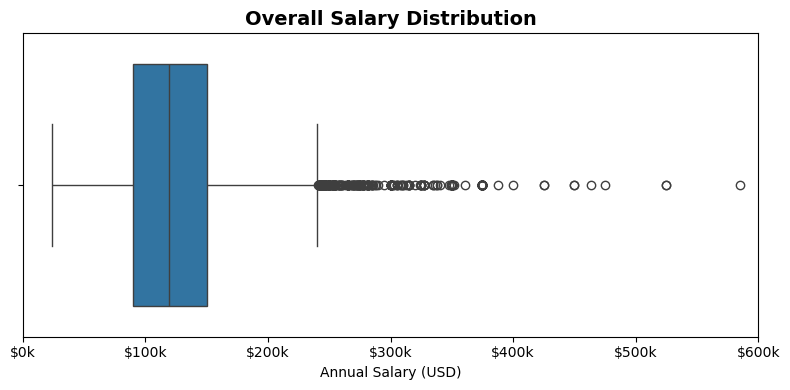

In [89]:
df_US_known = df_US_filtered[df_US_filtered['salary_year_avg'].notna()]

# plotting salary distriubtion
plt.figure(figsize=(8,4))
sns.boxplot(data=df_US_known['salary_year_avg'], orient='h')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1000)}k'))
plt.title('Overall Salary Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Annual Salary (USD)')
plt.xlim(0, 600000)
plt.tight_layout()
plt.show()

Note: As Salary data has many outliers, so using the median (instead of the mean) gives a more robust estimate of typical pay to fill out the None values. So, we will be replacing the nan value with the median salary of all job posting

### Filling out NA values
<hr>



Missing salary values were filled using a hierarchical median-based approach:<br>

- If a (job_location, job_title) group had at least <b>10 records</b>, its <b>median salary</b> was used to fill the missing salary values for that specific job type and location. <br> 
- Otherwise, the <b>overall median salary</b> for that job title was used to fill the missing value.  <br>

This ensures both contextual relevance and statistical reliability.<br>

In [90]:
# Checking data consistence for job location in Excel
loc_posting = df_US_filtered.groupby('job_location')['job_title_short'].count().sort_values(ascending=False)
loc_posting.to_excel('location_wise_posting.xlsx')
# Note: Anywhere and United states job posting represent same location

# Replacing anywhere with United States
df_US_filtered['job_location'] = df_US_filtered['job_location'].apply(
   lambda loc: loc if loc != 'Anywhere' else 'United States'
)

df_US_filtered.groupby('job_location')['job_title_short'].count().sort_values(ascending=False).head(7)

job_location
United States        21648
New York, NY          6707
Atlanta, GA           6064
Chicago, IL           4759
Washington, DC        4142
San Francisco, CA     3938
Dallas, TX            3556
Name: job_title_short, dtype: int64

In [91]:
df_US_filled = df_US_filtered.copy()
median_salaries = df_US_known.groupby('job_title_short')['salary_year_avg'].median()

# Step 1: finding medians by (job_location, job_title_short)
loc_title_medians = (
    df_US_known.groupby(['job_location', 'job_title_short'])
    .agg({'salary_year_avg': ['median', 'count']})
)
loc_title_medians.columns = ['median_salary', 'count']
loc_title_medians.sort_values(by='count', ascending=False, inplace=True)
loc_title_medians = loc_title_medians.reset_index()


# Step 2: function to fill out missing salaries
def fill_salary(row):
    subset = loc_title_medians[
        (loc_title_medians['job_location'] == row['job_location']) &
        (loc_title_medians['job_title_short'] == row['job_title_short'])
    ]

    if not subset.empty and subset.iloc[0]['count'] >= 10:
        return subset.iloc[0]['median_salary']
    else:
        return median_salaries[row['job_title_short']]

# Step 3: keeping the origin salary column
df_US_filled['original_salary_year_avg'] = df_US_filled['salary_year_avg']

# Step 4: fill out the na values
df_US_filled['salary_year_avg'] = df_US_filled.apply(
    lambda row: fill_salary(row) if pd.isna(row['salary_year_avg']) else row['salary_year_avg'],
    axis=1
)

df_US_filled.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,original_salary_year_avg
0,Data Analyst,Sr Data Analyst,"Tampa, FL",via Trabajo.org,Full-time,False,2023-01-01,False,False,United States,100000.0,"TWO95 International, Inc","[sql, sql server, excel, ssrs, power bi, power...",NaN
1,Data Analyst,Product Managers Data analyst,"Boston, MA",via LinkedIn,Full-time,False,2023-01-01,False,False,United States,90000.0,Diverse Lynx,[sql],NaN
2,Data Scientist,AI/ML Radar Research Data Scientist Jobs,"San Diego, CA",via Clearance Jobs,Full-time,False,2023-01-01,False,False,United States,135000.0,Leidos,"[python, matlab]",NaN
3,Data Analyst,Data Management Analyst,"Dallas, TX",via Indeed,Full-time,False,2023-01-01,False,False,United States,92500.0,KORE1 Technologies,"[sql, excel, tableau, terminal]",NaN
4,Data Scientist,Data Science Consultant,"San Francisco, CA",via Mendeley,Full-time,False,2023-01-01,False,False,United States,157500.0,Resume Library,None,NaN


In [92]:
# Exporting Cleaned data
df_US_filled.to_csv("data_cleaned_jobs.csv", index=False)

#### Dataset is now ready for futher analysis and visualization